## 1. Introduction

In this project, we'll work with data from the CIA World Factbook, a compendium of statistics about all of the countries on Earth. The Factbook contains demographic information like:

- population - The population as of 2015.
- population_growth - The annual population growth rate, as a percentage.
- area - The total land and water area.

This project uses the SQLite database, factbook.db, which can be downloaded from this [GitHub repo](https://github.com/factbook/factbook.sql/releases).  

In this notebook, we will showcase the Python SQLite workflow to explore, analyze, and visualize data from this database. 

First, we begin by familiarizing ourselves with the database.  We can do this by using pandas to run SQL queries and display the results neatly as a DataFrame object. We create a sqlite3.Connection instance first and then use pandas.read_sql_query(sql, con) to handle running the query and we see that this Data Base file contains two tables, facts and sqlite_sequence.

In [1]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("factbook.db")

q1 = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(q1, conn)

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


From here we see that the information is displayed in the table named facts, which will serve as the primary dataset.

## 2. Obtaining information on the dataset

For the two tables of facts and sqlite_sequence, we need to determine which one contains the data we want to use for this project.  

We do this by first importing pandas and sqlite3, using the conn method to connect to the factbook.db file, followed by the SQL query syntax.  We then apply the fetchall method to return information on the tables in the factbook.db file, with the following output:

In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("factbook.db")
cursor = conn.cursor()
q1 = "SELECT * FROM sqlite_master WHERE type='table';"

cursor.execute(q1).fetchall()

[('table',
  'facts',
  'facts',
  2,
  'CREATE TABLE "facts" ("id" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "code" varchar(255) NOT NULL, "name" varchar(255) NOT NULL, "area" integer, "area_land" integer, "area_water" integer, "population" integer, "population_growth" float, "birth_rate" float, "death_rate" float, "migration_rate" float, "created_at" datetime, "updated_at" datetime)'),
 ('table',
  'sqlite_sequence',
  'sqlite_sequence',
  3,
  'CREATE TABLE sqlite_sequence(name,seq)')]

From the above, we find that the table called 'facts' contains the information we need for, such as area_land, population, birth_rate etc.

Therefore, for the rest of this project, we will be using our SQL queries from the facts table.

We can then run a query on facts, using SELECT * to output the complete rows of the countries.  This will show all the columns so that we can better visualize the data.  

Using the LIMIT function, we can limit the output table to the first 5 rows:

In [3]:
q2 = "SELECT * FROM facts LIMIT 5"
pd.read_sql_query(q2, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


## 2. Summary Statistics

Here, we write a single SQL query that returns the:
- minimum population
- maximum population
- minimum population growth 
- maximum population growth

In [4]:
q3 = '''
SELECT min(population) as min_pop,
max(population) as max_pop,
min(population_growth) as min_pop_growth,
max(population_growth) as max_pop_growth
FROM facts
'''

pd.read_sql_query(q3, conn)

,min_pop,max_pop,min_pop_growth,max_pop_growth
0,0,7256490011,0.0,4.02


## 3. Exploring Outliers

In this example, we use two queries to find out which countries have the lowest and highest populations:

In [5]:
q4 = '''
SELECT * 
FROM facts
WHERE population == (SELECT MIN(population) FROM facts)
'''

pd.read_sql_query(q4, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None,2015-11-01 13:38:44.885746,2015-11-01 13:38:44.885746


In [6]:
q5 = '''
SELECT * 
FROM facts
WHERE population == (SELECT MAX(population) FROM facts)
'''

pd.read_sql_query(q5, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None,2015-11-01 13:39:09.910721,2015-11-01 13:39:09.910721


## 4. Histograms

It can be seen that the above results were outliers.
We can use the following SQL code to eliminate outliers:

WHERE population != (SELECT MAX(population) from facts) <br>
AND population != (SELECT MIN(population) from facts)

After removing the outliers, we can use the [pd.DataFrame.hist()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html) method to generate histograms for the data.  We will generate a 2 by 2 grid of histograms for the following columns:
- population
- population_growth
- birth_rate
- death_rate

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3267: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002206445E550>,
      dtype=object)

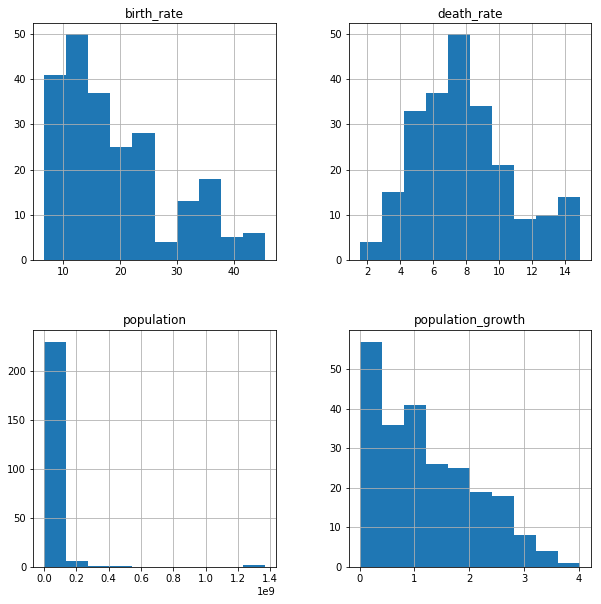

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

q6 = '''
SELECT population, population_growth, birth_rate, death_rate 
FROM facts
WHERE population != (SELECT MAX(population) from facts)
AND population != (SELECT MIN(population) from facts)
'''

pd.read_sql_query(q6, conn).hist(ax=ax)

## 5. Top 20 Countries with highest population density

In this example, we can rank the countries by population density, defined as total population divided by the area of the country's land mass, and rename this as popn_density.  This is done using the CAST() function to define total population and total land area as float variables.

We then use the ORDER function to rank the countries by popn_density, and use the LIMIT function to restrict the output table to show only the Top 20 countries.

In [8]:
q7 = '''
SELECT name, area_land, CAST(population as float)/CAST(area as float) as popn_density FROM facts
ORDER by popn_density DESC
LIMIT 20
'''

pd.read_sql_query(q7, conn)

,name,area_land,popn_density
0,Macau,28,21168.964286
1,Monaco,2,15267.500000
2,Singapore,687,8141.279770
3,Hong Kong,1073,6445.041516
4,Gaza Strip,360,5191.819444
5,Gibraltar,6,4876.333333
6,Bahrain,760,1771.859211
7,Maldives,298,1319.640940
8,Malta,316,1310.015823
9,Bermuda,54,1299.925926


## 6. Top 20 Countries with the highest ratios of water to land

Playing around with the dataset, we can find out each country's ratio of water area vs land area and rank them accordingly:

In [9]:
q8 = '''
SELECT name, CAST(area_water as float) / CAST(area_land as float) AS water_to_land_ratio
FROM facts
ORDER BY water_to_land_ratio DESC
LIMIT 20
'''

pd.read_sql_query(q8, conn)

,name,water_to_land_ratio
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673
5,Malawi,0.259396
6,Netherlands,0.225710
7,Uganda,0.222922
8,Eritrea,0.164356
9,Liberia,0.156240


## 7. Countries with more water than land
This query is similar to the last one, with the added feature that only countries with water area more than land area will be included, using the WHERE function.  It is interesting to note that only two countries in the world  fulfil this criteria. 

In [10]:
q8 = '''
SELECT name, CAST(area_water as float)/CAST(area_land as float) as water_to_land FROM facts
WHERE water_to_land > 1
ORDER by water_to_land DESC
LIMIT 20
'''

pd.read_sql_query(q8, conn)

,name,water_to_land
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231


## 8. Showing components of population growth

- The dataset has included key metrics such as Migration, Birth and Death rates.  - We would like to find out if these would be able to explain a country's level of population growth. 
- To test this, we define a new variable net_add = migration_rate + birth_rate - death_rate
- We find that it is indeed the case that net_add does do a pretty good job of explaining a country's population growth, as countries wiht the highest net_add ranks tend to also have the highest population rate.

In [11]:
q9 = '''
SELECT name, population, 
ROUND(migration_rate, 1) 'Migration Rate', 
ROUND(birth_rate, 1) 'Birth Rate',
ROUND(death_rate, 1) "Death Rate",
ROUND((migration_rate + birth_rate - death_rate), 1) net_add,
ROUND(population_growth, 1) growth
FROM facts
WHERE (migration_rate + birth_rate - death_rate) > 0
ORDER BY growth DESC
LIMIT 20
'''

pd.read_sql_query(q9, conn)

,name,population,Migration Rate,Birth Rate,Death Rate,net_add,growth
0,South Sudan,12042910,11.5,36.9,8.2,40.2,4.0
1,Burundi,10742276,0.0,42.0,9.3,32.7,3.3
2,Malawi,17964697,0.0,41.6,8.4,33.2,3.3
3,Niger,18045729,0.6,45.4,12.4,33.6,3.2
4,Uganda,37101745,0.7,43.8,10.7,33.8,3.2
5,Qatar,2194817,22.4,9.8,1.5,30.7,3.1
6,Burkina Faso,18931686,0.0,42.0,11.7,30.3,3.0
7,Mali,16955536,2.3,45.0,12.9,34.4,3.0
8,Ethiopia,99465819,0.2,37.3,8.2,29.3,2.9
9,Iraq,37056169,1.6,31.4,3.8,29.3,2.9


## 9. Conclusion
In this exercise we have demonstrated how to use Python to access Data Base files using the SQLite3 and pandas libraries, using the CIA Factbook as the dataset.  SQLite3 is particularly useful as it allows us to use the exact same SQLite query syntax as with any other GUI-based SQLite sofrware such as DB Browser.